In [36]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal
import xarray.ufuncs as xu
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [2]:
### For Narwhal ###
data_dir = '/data/deluge/scratch/ERA5/2D/daily/precip/'
    

In [86]:
xu.

SyntaxError: invalid syntax (3192492506.py, line 1)

In [3]:
"""
Funtion that calculates the Fourier coefficients and the explained variance of the Nth
first harmonics of a time series
Input:
   tseries: input time series
   nmodes : number of harmonics to retain (N)
   coefa  : Array with N (or 'nmodes') elements
   coefb  : Array with N (or 'nmodes') elements
   hvar   : Array with N (or 'nmodes') elements
   missval: Falg value for missing data
Output:
   coefa: Array of A coefficients of the Nth first harmonics
   coefb: Array of B coefficients of the Nth first harmonics
   hvar : Array of explained variance of the Nth first harmonics
"""
def Harmonics(tseries,nmodes=2,missval=np.nan):
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    newdim=len(tseries)  # removing missing data
    time=time
    tdata=tseries
    svar=np.sum((tdata[:]-np.mean(tdata))**2)//(newdim-1)
    nm=nmodes
    if 2*nm > newdim:
        nm=newdim/2
    coefa=np.zeros((nm))
    coefb=np.zeros((nm))
    hvar=np.zeros((nm))
    for tt in range(0,nm):
        Ak=np.sum(tdata[:]*xu.cos(2.*np.pi*(tt+1)*time[:]/float(newdim)))
        Bk=np.sum(tdata[:]*xu.sin(2.*np.pi*(tt+1)*time[:]/float(newdim)))
        coefa[tt]=Ak*2./float(newdim)
        coefb[tt]=Bk*2./float(newdim)
        hvar[tt]=newdim*(coefa[tt]**2+coefb[tt]**2)/(2.*(newdim-1)*svar)
    return hvar.argmax()

In [4]:
ds = xr.open_mfdataset(data_dir+'*.nc',parallel=True, chunks={'latitude': 100, 'longitude': 100, 'time': 366})

In [5]:
subset=ds.sel(latitude=slice(90,0), longitude=slice(200,330))

In [6]:
test = subset.load()

In [7]:
test

<xarray.Dataset>
Dimensions:    (time: 25598, bnds: 2, longitude: 261, latitude: 181)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01T15:00:00 ... 2020-01-31T11:00:00
  * longitude  (longitude) float32 200.0 200.5 201.0 201.5 ... 329.0 329.5 330.0
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 88.0 ... 1.5 1.0 0.5 0.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1950-01-01T07:00:00 ... 2020-01-31...
    precip     (time, latitude, longitude) float32 0.0009009 ... 0.01021
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 26 14:30:53 2021: cdo -b F32 daysum precip.195001.n...
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [8]:
precip = test['precip']*1000.0

In [5]:
### Create Daily precip from hourly ###
##daily_precip = precip.resample(time='1D').sum()

In [9]:
### Create The annual daily precip anomalies ###
annual_means = precip.groupby('time.year').mean(dim='time')

anomalies_withleap = precip.groupby('time.year') - annual_means
anomalies = anomalies_withleap.sel(time=~((anomalies_withleap.time.dt.month == 2) & (anomalies_withleap.time.dt.day == 29)))

In [ ]:



combined = xarray.concat(datasets, dim='example')

In [10]:
datasets = []


for i, k in anomalies.groupby('time.year'):
    wetseason = xr.apply_ufunc(
    Harmonics,
    k,
    input_core_dims=[["time"]],
    exclude_dims=set(["time"]),
    vectorize=True,
    )
    datasets.append(wetseason)

/home/gbromley/anaconda3/envs/Narwhal2021/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


In [12]:
combined = xr.concat(datasets, dim='year')

In [13]:
combined.to_netcdf('test.nc')

In [21]:
combined

<xarray.DataArray 'precip' (year: 71, latitude: 181, longitude: 261)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]]])
Coordinates:
  * longitude  (longitude) float32 200.0 200.5 201.0 201.5 ... 329.0 329.5 330.0
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 88.0 ... 1.5 1.0 0.5 0.0
Dimensions without coordinates: year

In [22]:
combined = combined + 1

In [26]:
combined.mean(dim='year').to_netcdf('average_wetseasons_na.nc')

ValueError: cannot rename 'precip' because it is not a variable or dimension in this dataset

In [80]:
tseries = datasets[0]
nmodes=2
mtot=len(tseries)
time=np.arange(1,mtot+1,1.)
newdim=len(tseries)  # removing missing data
time=time
tdata=tseries
svar=np.sum((tdata[:]-np.mean(tdata))**2)//(newdim-1)
nm=nmodes
if 2*nm > newdim:
    nm=newdim/2
coefa=np.zeros((nm))
coefb=np.zeros((nm))
hvar=np.zeros((nm))
for tt in range(0,nm):
    Ak=np.sum(tdata[:]*np.cos(2.*np.pi*(tt+1)*time[:]/float(newdim)))
    Bk=np.sum(tdata[:]*np.sin(2.*np.pi*(tt+1)*time[:]/float(newdim)))
    coefa[tt]=Ak*2./float(newdim)
    coefb[tt]=Bk*2./float(newdim)
    hvar[tt]=newdim*(coefa[tt]**2+coefb[tt]**2)/(2.*(newdim-1)*svar)
hvar.argmax()

ValueError: operands could not be broadcast together with shapes (365, 361, 720) (365,)

In [82]:
tseries

,Array,Chunk
Bytes,361.90 MiB,12.11 kiB
Shape,"(365, 361, 720)","(31, 10, 10)"
Count,19272217 Tasks,31968 Chunks
Type,float32,numpy.ndarray


In [84]:
test = xr.apply_ufunc(
    Harmonics,
    tseries,
    input_core_dims=[["time"]],
    exclude_dims=set(["time"]),
    vectorize=True,
    dask="allowed",
    )

ValueError: operands could not be broadcast together with shapes (361, 720, 365) (361,)

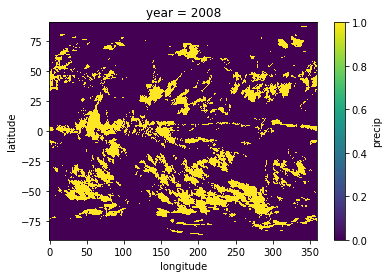

In [53]:
test.plot()

In [255]:
y = test4.rolling(window=15,min_periods=5).mean().cumsum().to_numpy()[4:]

In [33]:
harm_test = Harmonics(tseries=anomalies.isel(latitude=100, longitude=100),nmodes=3, missval=np.nan)

In [34]:
harm_test

0

In [8]:
def bower_wetseason(x):
    x = pd.Series(x)
    wet_season = x.rolling(window=5,min_periods=5).mean().cumsum().idxmin() + 1
    return wet_season
        
    

In [ ]:
# function that takes arguments of unequal length and requires vectorizing
def theil_senn(y):
    result = stats.theilslopes(y,x=np.arange(len(y)),alpha=0.95)
    slope = result[0]
    max_slope = result[3]
    min_slope = result[2]
    if min_slope <= 0 <= max_slope: 
        return np.nan
    else:
        return slope 

In [271]:
wetseason = xr.apply_ufunc(
    Harmonics,
    test,
    input_core_dims=[["time"]],
    exclude_dims=set(["time"]),
    vectorize=True,
)

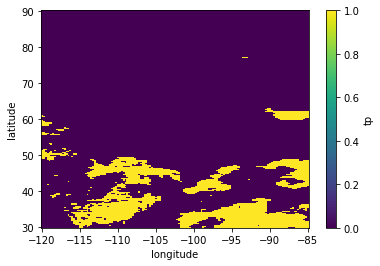

In [273]:
wetseason.plot()

In [19]:
wetseason = wetseason.sel(latitude=slice(60,30))

In [21]:
wetseason

<xarray.DataArray 'tp' (latitude: 121, longitude: 141)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])
Coordinates:
  * longitude  (longitude) float32 -120.0 -119.8 -119.5 ... -85.5 -85.25 -85.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 30.5 30.25 30.0

In [11]:
levels = np.arange(0,365,15)

In [27]:
levels = [1,2,3]

In [27]:
p.axes

<GeoAxesSubplot:xlabel='longitude', ylabel='latitude'>

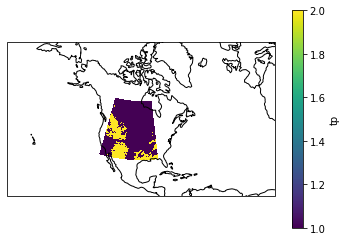

In [28]:
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)

p = wetseason.plot(transform=ccrs.PlateCarree(),  # the data's projection  # multiplot settings # for a sensible figsize
             subplot_kws={'projection': map_proj})  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines()
p.axes.set_extent([-160, -30, 5, 75])

/home/gbromley/anaconda3/envs/Narwhal2021/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


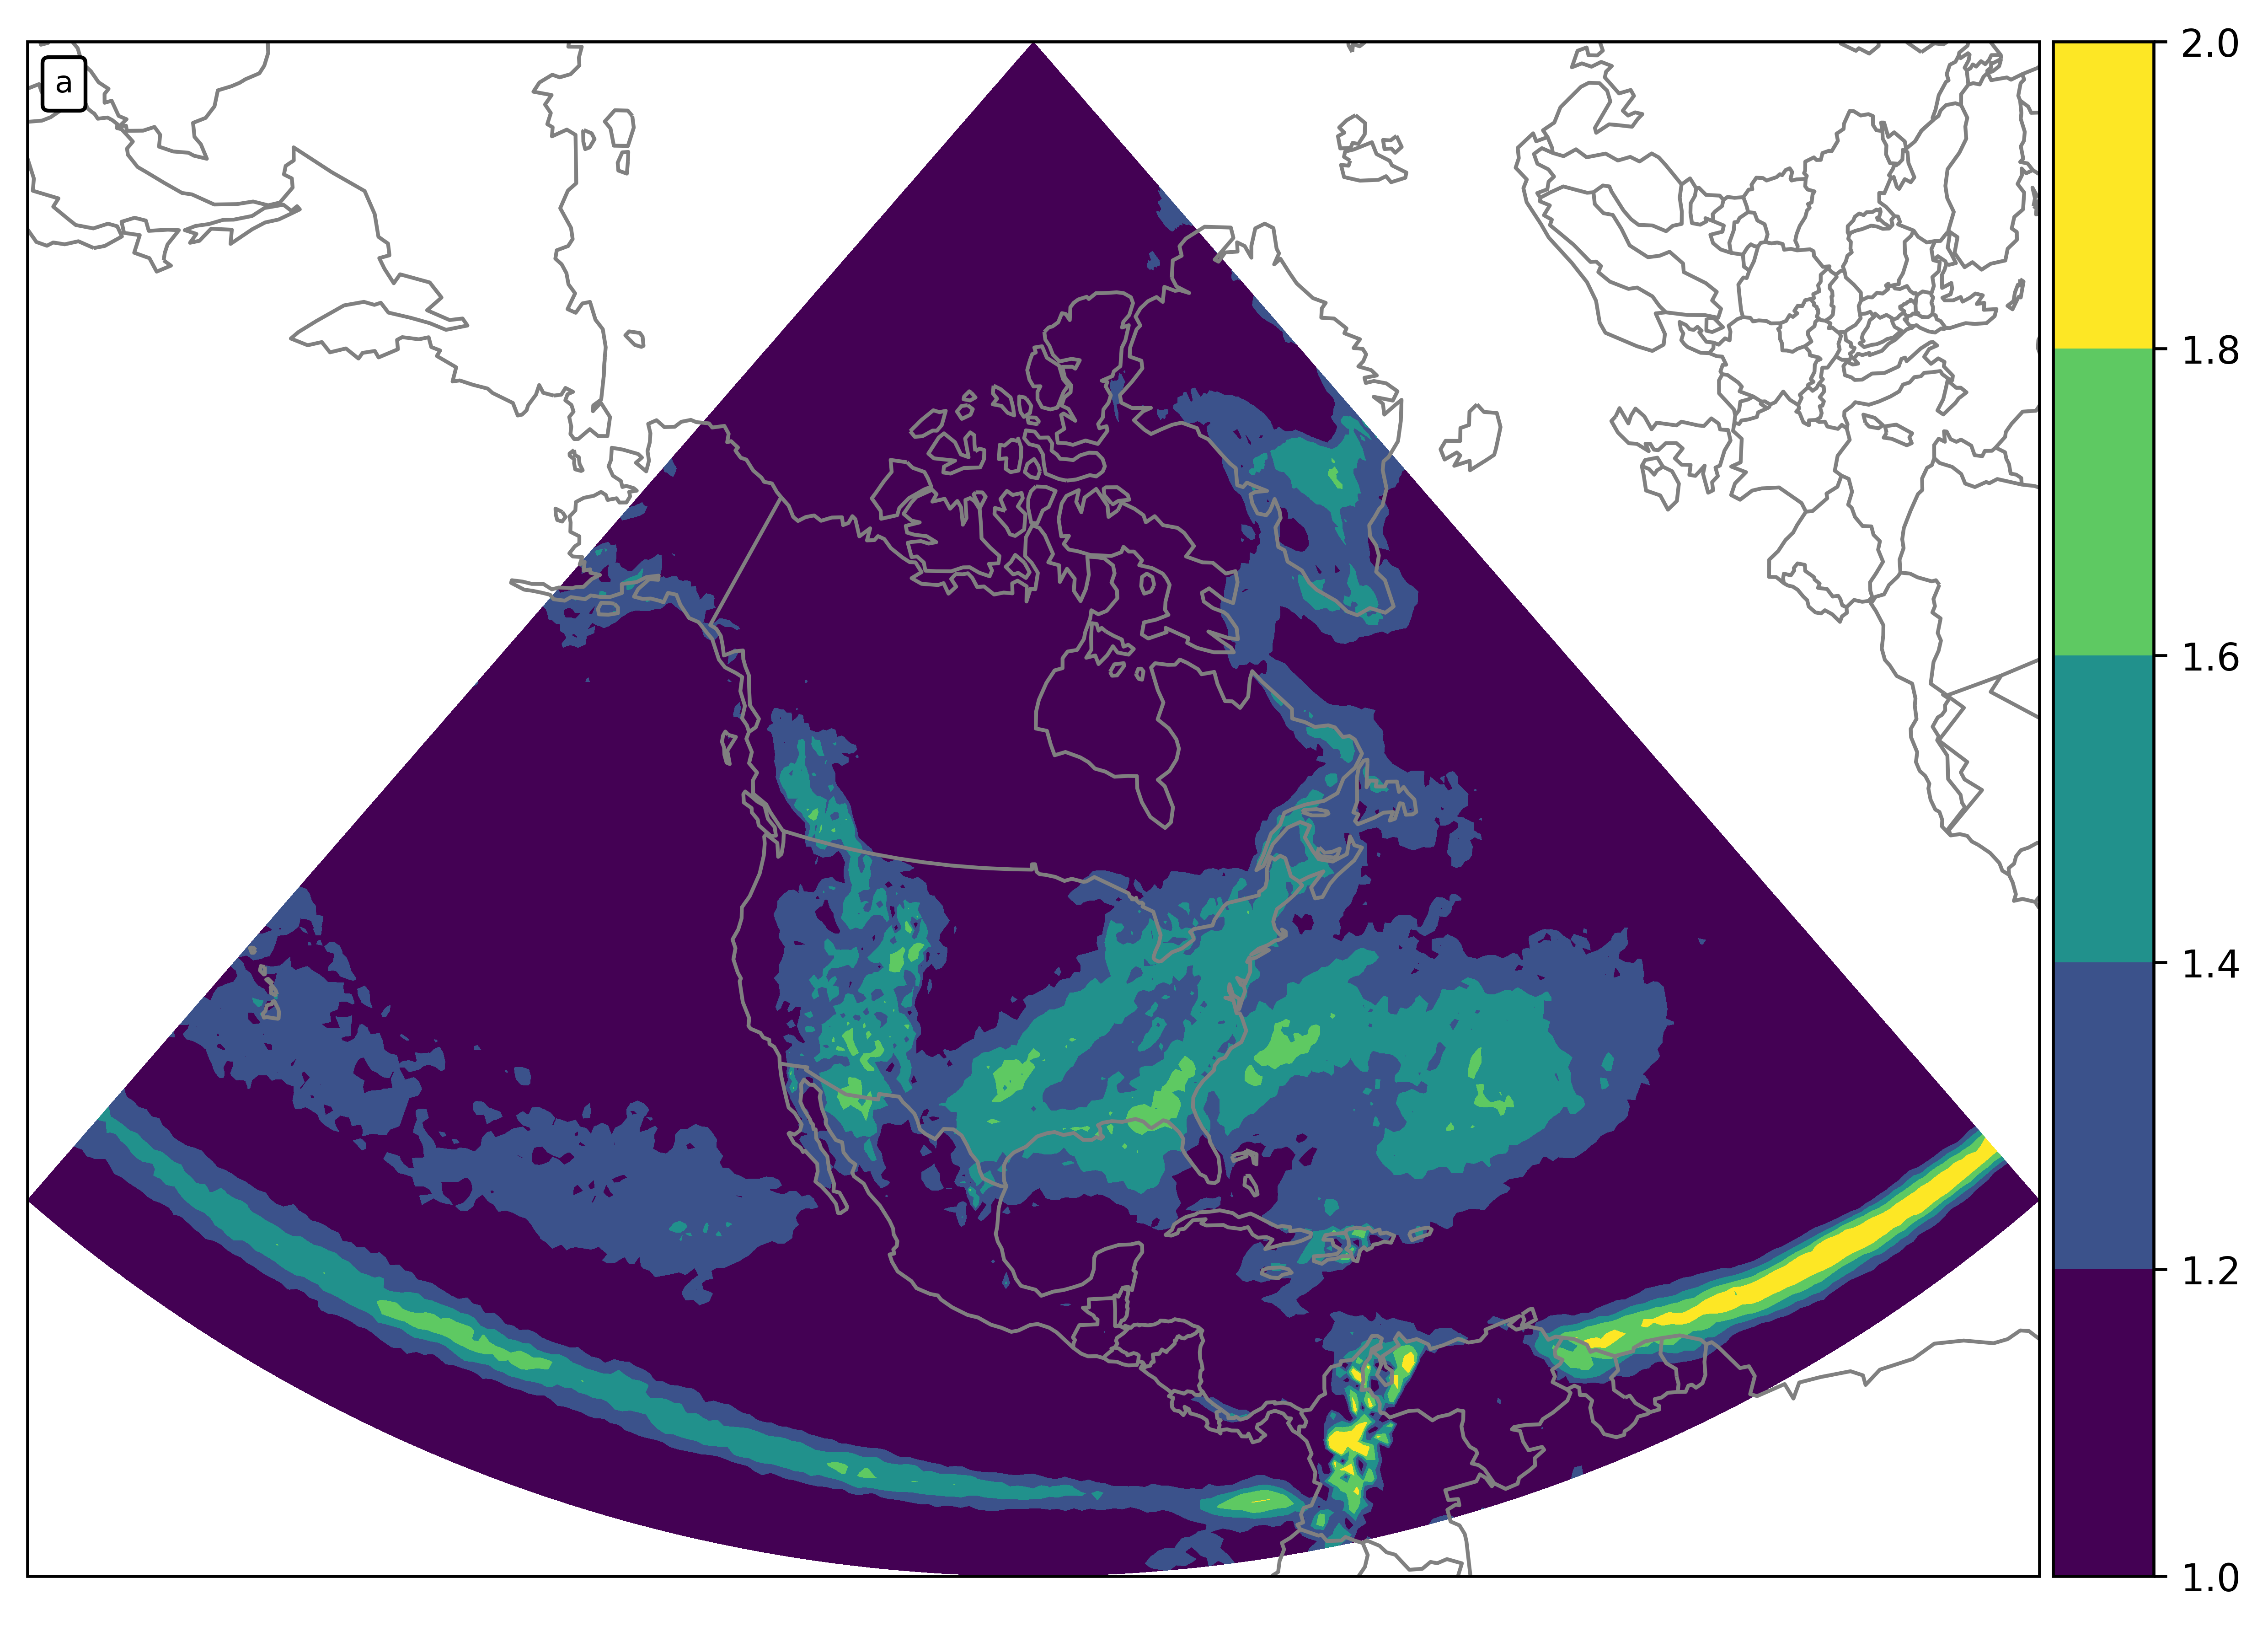

In [38]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
#cmap = mpl.cm.RdBu_r


f, ax1 = plt.subplots(1, 1, figsize=(10, 13), dpi=600, subplot_kw={'projection': map_proj})
p = combined.mean(dim='year').plot.contourf(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False)


### Setting 1st plot parameters ###
ax1.coastlines(color='grey')
ax1.add_feature(cartopy.feature.BORDERS, color='grey')
#ax1.add_feature(cfeature.STATES, color='grey')
#ax1.set_xticks(np.arange(-180,181, 40))
#ax1.set_yticks(np.arange(-90,91,15))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
at = AnchoredText("a",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
plt.colorbar(p, cax=cax)